Write a function to transcribe audio to text.

In [1]:

import pandas as pd
from google.cloud import speech
import os

def transcribe_audio(file_path) -> object:
	""" Transcribes audio file to text using Google Cloud API speech-to-text. Returns full response """
	client = speech.SpeechClient()

	with open(file_path, "rb") as audio_file:
		content = audio_file.read()

	audio = speech.RecognitionAudio(content=content)
	config = speech.RecognitionConfig(
		language_code="en-US", 
	)

	response = client.recognize(config=config, audio=audio)

	return response

current_path = os.getcwd()


Transcribe given audio sample and read the dataset.

In [2]:
transcript1 = transcribe_audio(os.path.join(current_path, 'sample_customer_call.wav'))
transcript1_text = transcript1.results[0].alternatives[0].transcript

df = pd.read_csv('customer_call_transcriptions.csv')
df

,text,sentiment_label
0,how's it going Arthur I just placed an order w...,negative
1,yeah hello I'm just wondering if I can speak t...,neutral
2,hey I receive my order but it's the wrong size...,negative
3,hi David I just placed an order online and I w...,neutral
4,hey I bought something from your website the o...,negative
...,...,...
137,hi there I just wanted to say that I'm really ...,positive
138,hello I just wanted to thank the team for help...,positive
139,hey I just wanted to say that the warranty pro...,positive
140,hi I'm just calling to say that I'm a big fan ...,positive


Check for null entries

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             142 non-null    object
 1   sentiment_label  142 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB


Check for dataset balance

In [4]:
df['sentiment_label'].value_counts()

sentiment_label
neutral     57
negative    43
positive    42
Name: count, dtype: int64

At first the dataset was imbalanced with only 2 positive samples. So I generated more "transcripts" using LLM Gemini.

Generate a word cloud:

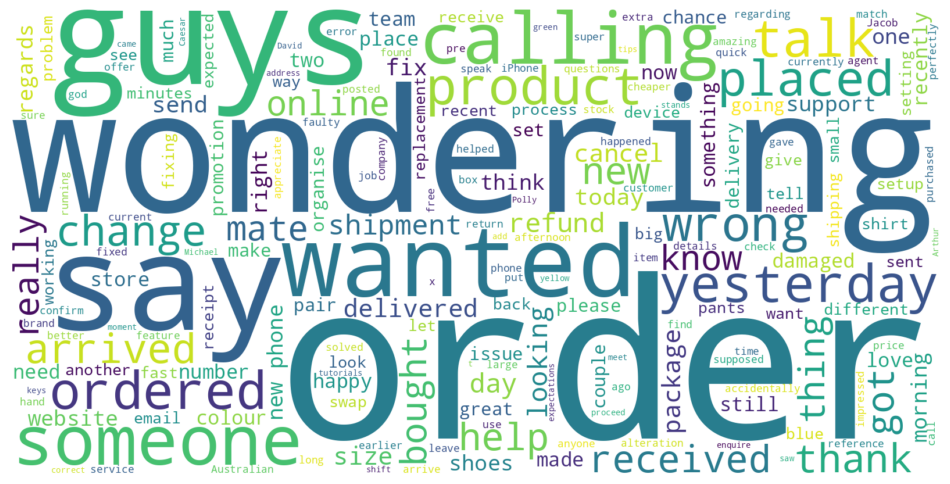

In [5]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

stop_words = list(STOPWORDS)
stop_words.extend(['hi', 'hey', 'yeah', 'hello'])

calls = " ".join(df['text'])
word_cloud = WordCloud(stopwords=stop_words, background_color='white', width=1600, height=800).generate(calls)

plt.figure(figsize=(12, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

Vectorize meaningful words with Tfidf algorithm. This counts the frequency of words in the text and evaluates the importance of the words depending on it's usage in all transcriptions.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# pattern to split transcriptions to words
pattern = r"\b[a-zA-Z']+\b"

# ngram_range is set to "register" not only single words but pairs of words too because it should be very
# useful for context. max_features is set to 300 because we want to keep only the most important words
vect = TfidfVectorizer(token_pattern=pattern, stop_words=stop_words, ngram_range=(1, 2), max_features=300)

vect.fit(df['text'])

tokenized_features = vect.transform(df['text'])

features = pd.DataFrame(tokenized_features.toarray(), columns=vect.get_feature_names_out())

features

,accidentally,afternoon,afternoon wrong,agent,ago,amazing,another,anyone,anyone talk,appreciate,...,wondering help,wondering know,wondering speak,working,wrong,wrong size,wrong someone,yesterday,yesterday arrive,yesterday arrived
0,0.37493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.245902,0.000000,0.0,0.000000,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.3663,0.0,0.000000,0.000000,0.0,0.231372,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.284637,0.408323,0.0,0.000000,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
138,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
139,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
140,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


Create some more features that might contribute to the model's performance

In [7]:
# add a column that counts the number of words
df['char_count'] = df['text'].str.count(r"\S")

# add a column that counts the number of words
df['word_count'] = df['text'].str.count(pattern)

# add a column that counts average word length
df['average_word_length'] = df['char_count'] / df['word_count']

df

,text,sentiment_label,char_count,word_count,average_word_length
0,how's it going Arthur I just placed an order w...,negative,114,28,4.071429
1,yeah hello I'm just wondering if I can speak t...,neutral,75,17,4.411765
2,hey I receive my order but it's the wrong size...,negative,57,16,3.562500
3,hi David I just placed an order online and I w...,neutral,100,26,3.846154
4,hey I bought something from your website the o...,negative,129,34,3.794118
...,...,...,...,...,...
137,hi there I just wanted to say that I'm really ...,positive,79,19,4.157895
138,hello I just wanted to thank the team for help...,positive,74,19,3.894737
139,hey I just wanted to say that the warranty pro...,positive,74,18,4.111111
140,hi I'm just calling to say that I'm a big fan ...,positive,73,20,3.650000


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


X = pd.concat([features, df[['char_count', 'word_count', 'average_word_length']]], axis=1)
Y = df['sentiment_label'].map({'negative': 0, 'neutral': 1, 'positive': 2})

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

forest = RandomForestClassifier(random_state=42).fit(X_train, Y_train)

Y_pred = forest.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00         7

    accuracy                           0.97        29
   macro avg       0.97      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29



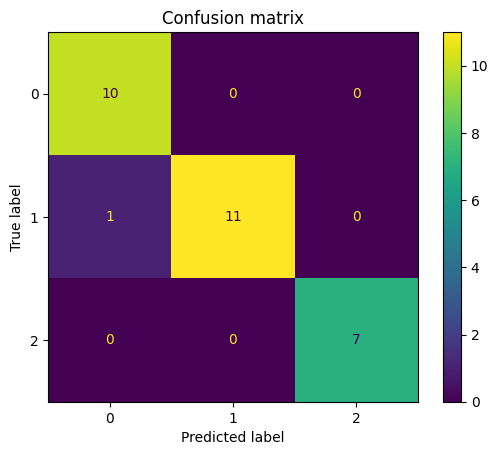

In [9]:
ConfusionMatrixDisplay.from_estimator(forest, X_test, Y_test)
plt.title('Confusion matrix')
plt.show()

In [10]:
df_importances = pd.DataFrame({
	"feature": X.columns,
	"importance": forest.feature_importances_
}).sort_values(by="importance", ascending=False)

df_importances

,feature,importance
285,wondering,0.093853
279,wanted,0.067854
212,say,0.056118
300,char_count,0.048564
301,word_count,0.044358
...,...,...
37,cheaper,0.000000
271,think think,0.000000
268,things receive,0.000000
10,arrive,0.000000


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

train_texts, val_texts, train_labels, val_labels = train_test_split(
	df['text'].tolist(), 
	df['sentiment_label'].tolist(), 
	test_size=0.2
)

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(text):
	return tokenizer(text, truncation=True, max_length=128)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

class SupportDataset(torch.utils.data.Dataset):
	def __init__(self, encodings, labels):
		self.encodings = encodings
		self.labels = labels

	def __getitem__(self, idx):
		item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
		item['labels'] = torch.tensor(self.labels[idx])
		return item

	def __len__(self):
		return len(self.labels)

train_dataset = SupportDataset(train_encodings, train_labels)
val_dataset = SupportDataset(val_encodings, val_labels)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
	 
	
training_args = TrainingArguments(
	output_dir='./results',
	num_train_epochs=3,          
	per_device_train_batch_size=8,
	eval_strategy="epoch",    
	logging_dir='./logs',
)

trainer = Trainer(
	model=model,
	args=training_args,
	train_dataset=train_dataset,
	eval_dataset=val_dataset,
)

trainer.train()

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Python312\Lib\site-packages\torch\cuda\__init__.py:182: UserWarning: cudaGetDeviceCount() returned cudaErrorNotSupported, likely using older driver or on CPU machine (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:88.)
  return torch._C._cuda_getDeviceCount() > 0
c:\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory'

TypeError: new(): invalid data type 'str'